This is the notebook to use to generate a figure. 
For this, you need to have to have the following: 
- the simulated dataset (w3c)
- the set `.env` at the root with `$WORKSPACE` and `$DEMAPPER`

## Step 1) run the Mappers on the configs

The following script will generate the Mapper results, shape graphs, plots, and stats for each configuration set in the configuration.
We will run two sets of DeMapper configurations (they will run for a while):

```
./code/utils/run_mapper.sh --poolsize 4 mappers_w3c_dists1.json w3c

./code/utils/run_mapper.sh --poolsize 4 mappers_w3c_dists2.json w3c

./code/utils/run_mapper.sh --poolsize 4 mappers_w3c_dists3.json w3c-wnoise

./code/utils/run_mapper.sh --poolsize 4 mappers_w3c_dists4.json w3c-hightr

```

Note that we run on 3 dataset types: `w3c`, `w3c-wnoise`, `w3c-hightr`. We have to run the analysis separately for each one of those datasets

## Step 2a) `w3c` dataset: Analyze the created Mappers graphs (circleness, ...)

Once all the mappers have been computed for the configs, you should analyze the shape graphs based on the circleness criteria and the other statistics:

```
CONF=mappers_w3c_dists1.json
CONF=mappers_w3c_dists2.json
```

Run the below for each of the above configurations:

```
source .env
# module load matlab # Maybe run this if you are running in SLURM
COHORT_PATH="$WORKSPACE/data/w3c/cohort.csv"
DATAFOLDER="$WORKSPACE/results/w3c/${CONF}/"
OUTPUT_DIR="$WORKSPACE/results/w3c/analysis/${CONF}/"
ARGS="datafolder='${DATAFOLDER}'; cohort_path='${COHORT_PATH}'; output_dir='${OUTPUT_DIR}';"
matlab -nodesktop -r "${ARGS} run('$WORKSPACE/code/w3c/circle_test_multitiming.m')"

```

For the rest of the criteria, run the following python script:

```
python3 $WORKSPACE/code/utils/cache.py compute_stats \
    $WORKSPACE/data/w3c/cohort.csv \
    $WORKSPACE/results/w3c/${CONF}/ \
    --output_dir $WORKSPACE/results/w3c/analysis/${CONF}/
```

The above two commands will generate tables of stats within `analysis/${CONF}` directory. 

## Step 2b) `w3c-wnoise` dataset: Analyze the created Mappers graphs (circleness, ...)

Once all the mappers have been computed for the configs, you should analyze the shape graphs based on the circleness criteria and the other statistics:

```
CONF=mappers_w3c_dists3.json
```

Run the below for each of the above configurations:

```
source .env
# module load matlab # Maybe run this if you are running in SLURM
COHORT_PATH="$WORKSPACE/data/w3c-wnoise/cohort.csv"
DATAFOLDER="$WORKSPACE/results/w3c-wnoise/${CONF}/"
OUTPUT_DIR="$WORKSPACE/results/w3c-wnoise/analysis/${CONF}/"
ARGS="datafolder='${DATAFOLDER}'; cohort_path='${COHORT_PATH}'; output_dir='${OUTPUT_DIR}';"
matlab -nodesktop -r "${ARGS} run('$WORKSPACE/code/w3c/circle_test_multitiming.m')"

```

For the rest of the criteria, run the following python script:

```
python3 $WORKSPACE/code/utils/cache.py compute_stats \
    $WORKSPACE/data/w3c-wnoise/cohort.csv \
    $WORKSPACE/results/w3c-wnoise/${CONF}/ \
    --output_dir $WORKSPACE/results/w3c-wnoise/analysis/${CONF}/
```

The above two commands will generate tables of stats within `analysis/${CONF}` directory. 

## Step 2c) `w3c-hightr` dataset: Analyze the created Mappers graphs (circleness, ...)

Once all the mappers have been computed for the configs, you should analyze the shape graphs based on the circleness criteria and the other statistics:

```
CONF=mappers_w3c_dists4.json
```

Run the below for each of the above configurations:

```
source .env
# module load matlab # Maybe run this if you are running in SLURM
COHORT_PATH="$WORKSPACE/data/w3c-hightr/cohort.csv"
DATAFOLDER="$WORKSPACE/results/w3c-hightr/${CONF}/"
OUTPUT_DIR="$WORKSPACE/results/w3c-hightr/analysis/${CONF}/"
ARGS="datafolder='${DATAFOLDER}'; cohort_path='${COHORT_PATH}'; output_dir='${OUTPUT_DIR}';"
matlab -nodesktop -r "${ARGS} run('$WORKSPACE/code/w3c/circle_test_multitiming.m')"

```

For the rest of the criteria, run the following python script:

```
python3 $WORKSPACE/code/utils/cache.py compute_stats \
    $WORKSPACE/data/w3c-hightr/cohort.csv \
    $WORKSPACE/results/w3c-hightr/${CONF}/ \
    --output_dir $WORKSPACE/results/w3c-hightr/analysis/${CONF}/
```

The above two commands will generate tables of stats within `analysis/${CONF}` directory. 

## Step 3) Generate the figures

In [1]:
import csv
import os
import math
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import Image as IPyImage, display
from PIL import Image
from scipy import stats

sns.set(rc={'figure.facecolor':'white'})

# demapper imports for the analysis
from code.utils.analyze import extract_dataset, get_all_parameters
from code.utils.config_w3c import DATASETS, FILTERS
from code.utils.config_mapper import extract_params_f
from code.utils.utils import filter_dataframe, count_passing, add_col_passing

### Figure (a)

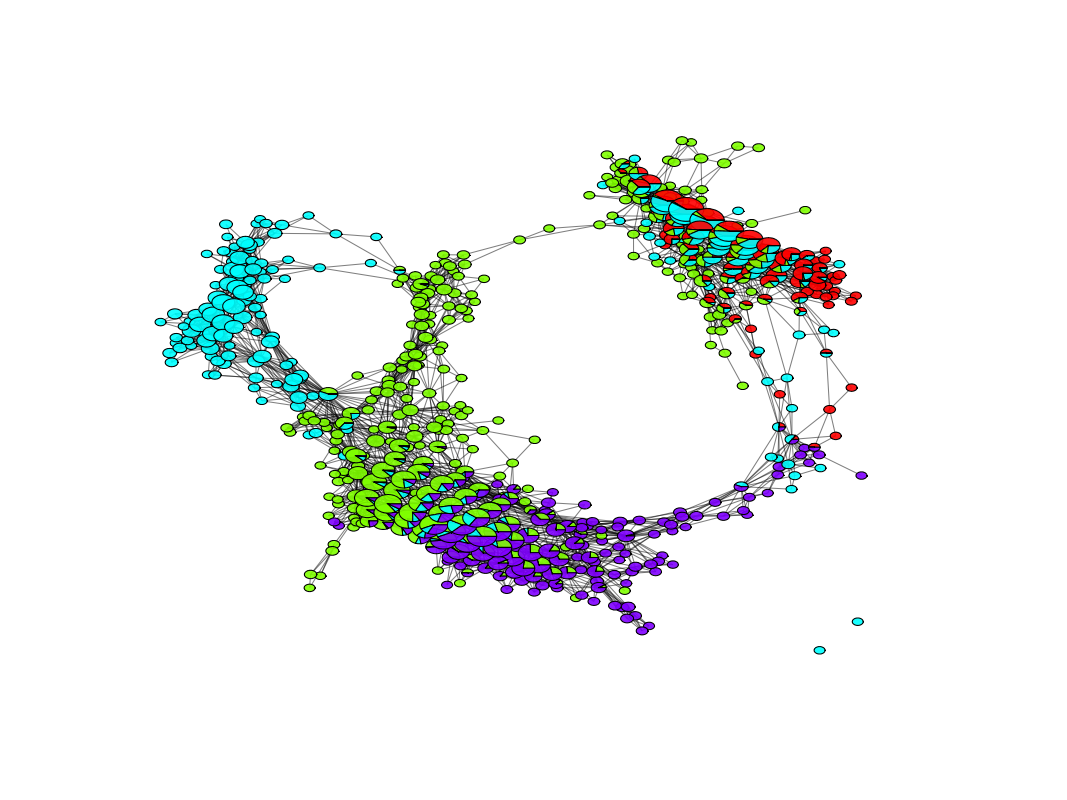

In [6]:
imgpath = 'results/w3c/mappers_w3c_dists1.json/SBJ99/DistsBDLMapper_correlation_20_60/plot_task-G.png'
display(IPyImage(filename=os.path.join('../', imgpath)))

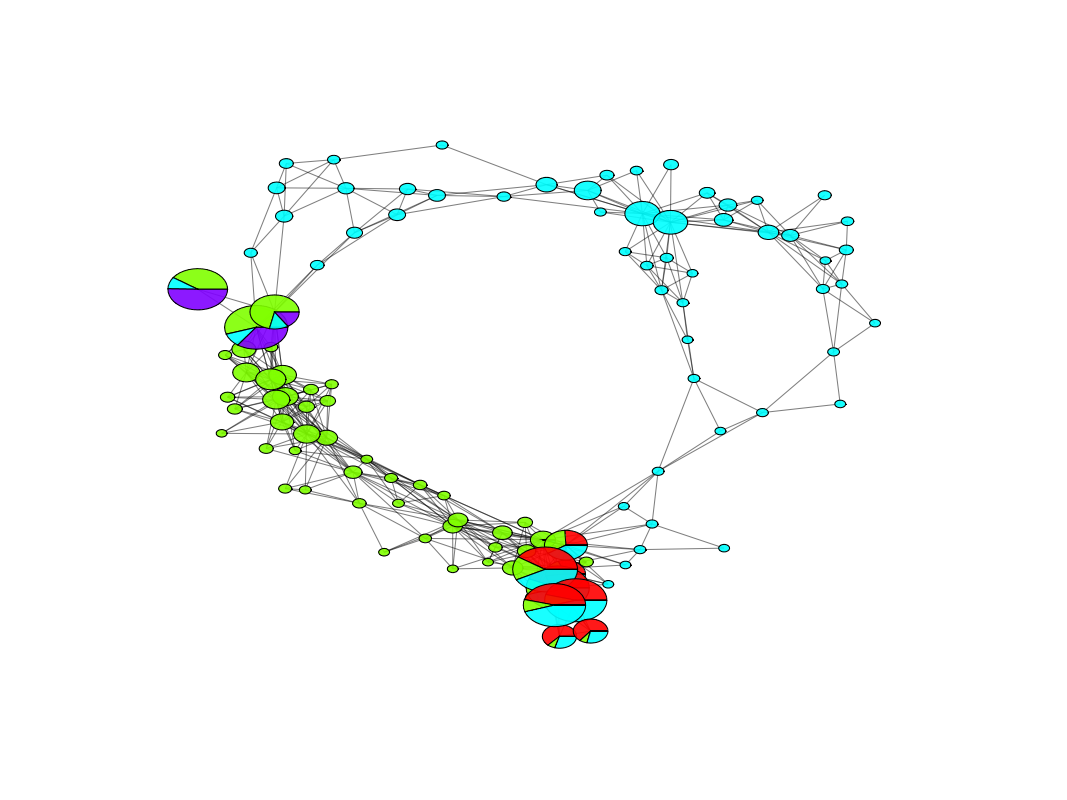

In [7]:
imgpath = 'results/w3c/mappers_w3c_dists1.json/SBJ99/DistsBDLMapper_euclidean_10_60/plot_task-G.png'
display(IPyImage(filename=os.path.join('../', imgpath)))

### Figures 5b, 5c
Both figures depend on running the config (mappers and analysis) for: "mappers_w3c_dists3". 

Make sure you have run Step 2a above before running those scripts.

In [4]:
PICKED_DATASET = 'w3c-dists2'

datadir = DATASETS[PICKED_DATASET]
stats_path = os.path.join(datadir, 'compute_stats-combined.csv')
results_path = os.path.join(datadir, 'scores-all.csv')

filters = {
    'SBJ': ['SBJ99'],
}


# Extract geodesic distances mappers
filter_by = FILTERS[PICKED_DATASET][0]
df, max_values = extract_dataset(stats_path, results_path, filter_by, extract_params_f)
target_metrics_limits_geo = {
    'TransitionBetweeness': [0, max_values['TransitionBetweeness'] * 0.99], # Need the data first, add later
    'coverage_nodes': [0.7, 1.0],
    'distances_entropy': [2.0, 10000.0],
    'hrfdur_stat': [0.15, 1.0],
}
df_geodists = filter_dataframe(df, filters)
print('After filter: ', len(df_geodists))

# Extract non-geodesic distances mappers
filter_by = FILTERS[PICKED_DATASET][1]
df, max_values = extract_dataset(stats_path, results_path, filter_by, extract_params_f)
target_metrics_limits_nongeo = {
    'TransitionBetweeness': [0, max_values['TransitionBetweeness'] * 0.99], # Need the data first, add later
    'coverage_nodes': [0.7, 1.0],
    'distances_entropy': [2.0, 10000.0],
    'hrfdur_stat': [0.15, 1.0],
}
df_nongeodists = filter_dataframe(df, filters)
print('After filter: ', len(df_nongeodists))


len(stats):  2375
len(results):  2375
After filter:  2250
len(stats):  2375
len(results):  2375
After filter:  125


In [5]:
# Count the mappers that pass the criteria for circleness
dists = ['euclidean', 'cityblock', 'chebychev',  'cosine', 'correlation']
Kvals = [3, 4, 6, 8, 12, 16, 24, 32, 48, 64, 96, 128, 256, 384, 512] # df_geodists['K'].drop_duplicates().to_numpy()

table = []
# counts = {d:{} for d in dists}
for dist in dists:
    fdf = filter_dataframe(df_nongeodists, { 'dist': [dist] })
    cnt = count_passing(fdf, target_metrics_limits_nongeo)
    table.append({
        'dist': dist,
        'K': 'non geodesic',
        'count': cnt,
        'perc': cnt / len(fdf) * 100,
        
    })
    for k in Kvals:
        fdf = filter_dataframe(df_geodists, { 'dist': [dist], 'K': [k] })
        cnt = count_passing(fdf, target_metrics_limits_geo)
        table.append({
            'dist': dist,
            'K': 'geodesic k={}'.format(k),
            'count': cnt,
            'perc': cnt / len(fdf) * 100.0
        })
        
counts_df = pd.DataFrame(data=table)


In [6]:
# Generate the 5x5 orange plots for geodesic distances

sbj = 'SBJ99'
for dist in dists:
    fdf = filter_dataframe(df_geodists, { 'dist': [dist], 'K': [12] })
    fdf = add_col_passing(fdf, target_metrics_limits_geo)
    fdf = fdf.pivot(index='R', columns='G', values='passing').sort_values('R', ascending=False)
    fdf = fdf * 0.75

    plt.figure(figsize=(2.5,2.5))
    ax = sns.heatmap(fdf, cbar=False, vmax=1.0)
    if dist == 'euclidean':
        ax.set_xlabel('Gain')
        ax.set_ylabel('Resolution')
    else:
        ax.set(xlabel=None, ylabel=None)
        ax.tick_params(bottom=False, left=False,
                labelleft=False, labelbottom=False)

    save_path = os.path.join(datadir, 'dists-geo_{}_k{}_{}_box.png'.format(dist, 12, sbj))
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()

In [7]:
# Generate the 5x5 orange plots for non-geodesic distances

for dist in dists:
    fdf = filter_dataframe(df_nongeodists, { 'dist': [dist] })
    fdf = add_col_passing(fdf, target_metrics_limits_nongeo)
    fdf = fdf.pivot(index='R', columns='G', values='passing').sort_values('R', ascending=False)
    fdf = fdf * 0.75

    plt.figure(figsize=(2.5,2.5))
    ax = sns.heatmap(fdf, cbar=False, vmax=1.0)
    ax.set(xlabel=None, ylabel=None)
    ax.tick_params(bottom=False, left=False,
            labelleft=False, labelbottom=False)

    save_path = os.path.join(datadir, 'dists-nongeo_{}_{}_box.png'.format(dist, sbj))
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()

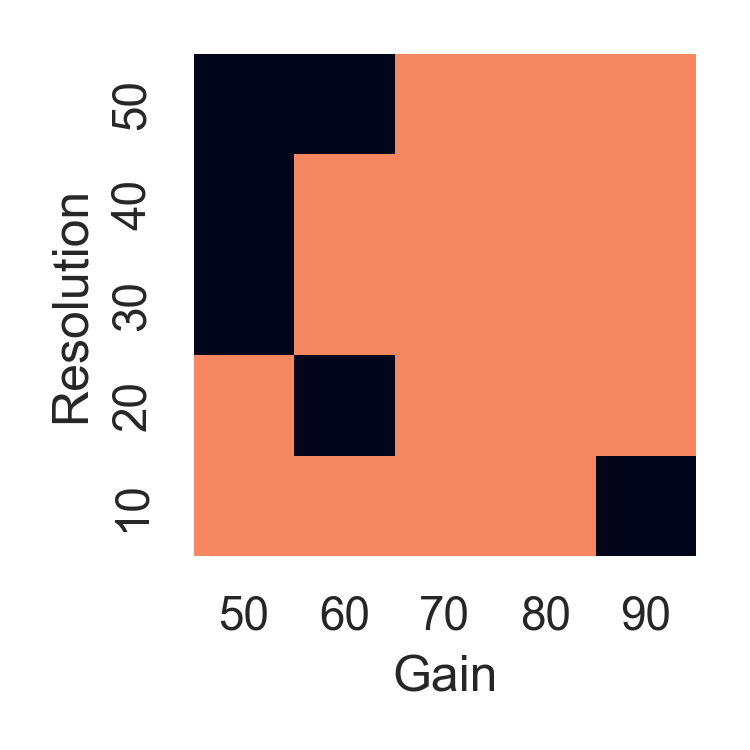

In [8]:
imgpath = 'results/w3c/analysis/mappers_w3c_dists2.json/dists-geo_euclidean_k12_SBJ99_box.png'
display(IPyImage(filename=os.path.join('../', imgpath)))

The rest of the subplots of figure 5b are at the same path, with the appropriate filenames: 

```
results/w3c/analysis/mappers_w3c_dists2.json/dists-geo_euclidean_k12_SBJ99_box.png
results/w3c/analysis/mappers_w3c_dists2.json/dists-nongeo_cosine_SBJ99_box.png
results/w3c/analysis/mappers_w3c_dists2.json/dists-nongeo_correlation_SBJ99_box.png
results/w3c/analysis/mappers_w3c_dists2.json/dists-nongeo_euclidean_SBJ99_box.png
results/w3c/analysis/mappers_w3c_dists2.json/dists-geo_cosine_k12_SBJ99_box.png
results/w3c/analysis/mappers_w3c_dists2.json/dists-geo_chebychev_k12_SBJ99_box.png
```

In [11]:
# Generate figure 5c
sns.set_style(style='white') 
f,ax = plt.subplots(figsize=(4,5))
sns.boxplot(
    data=counts_df[counts_df['K'] != 'non geodesic'], y="count", x='dist',
    color=[0.6,1.0,0], ax=ax)
sns.swarmplot(
    data=counts_df[counts_df['K'] == 'non geodesic'], y="count", x="dist", 
    color=[1.0,0.0,1.0], marker="X", size=10, ax=ax)

sns.despine(left=True)
ax.set_ylim(-0.8, 29)
ax.set_xlabel('')
ax.set_ylabel('count of correct Mapper graphs', color='#F58860')
ax.tick_params(colors='#F58860', which='both', axis='y')
ax.grid(axis='y', alpha=0.4)
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=70)

plt.legend(
    ['Geodesic', 'Non-geodesic'])
plt.tight_layout()
# plt.show()
save_path = os.path.join(datadir, 'distances_distribution_boxplot_v2.png')
plt.savefig(save_path, dpi=300)
plt.close()

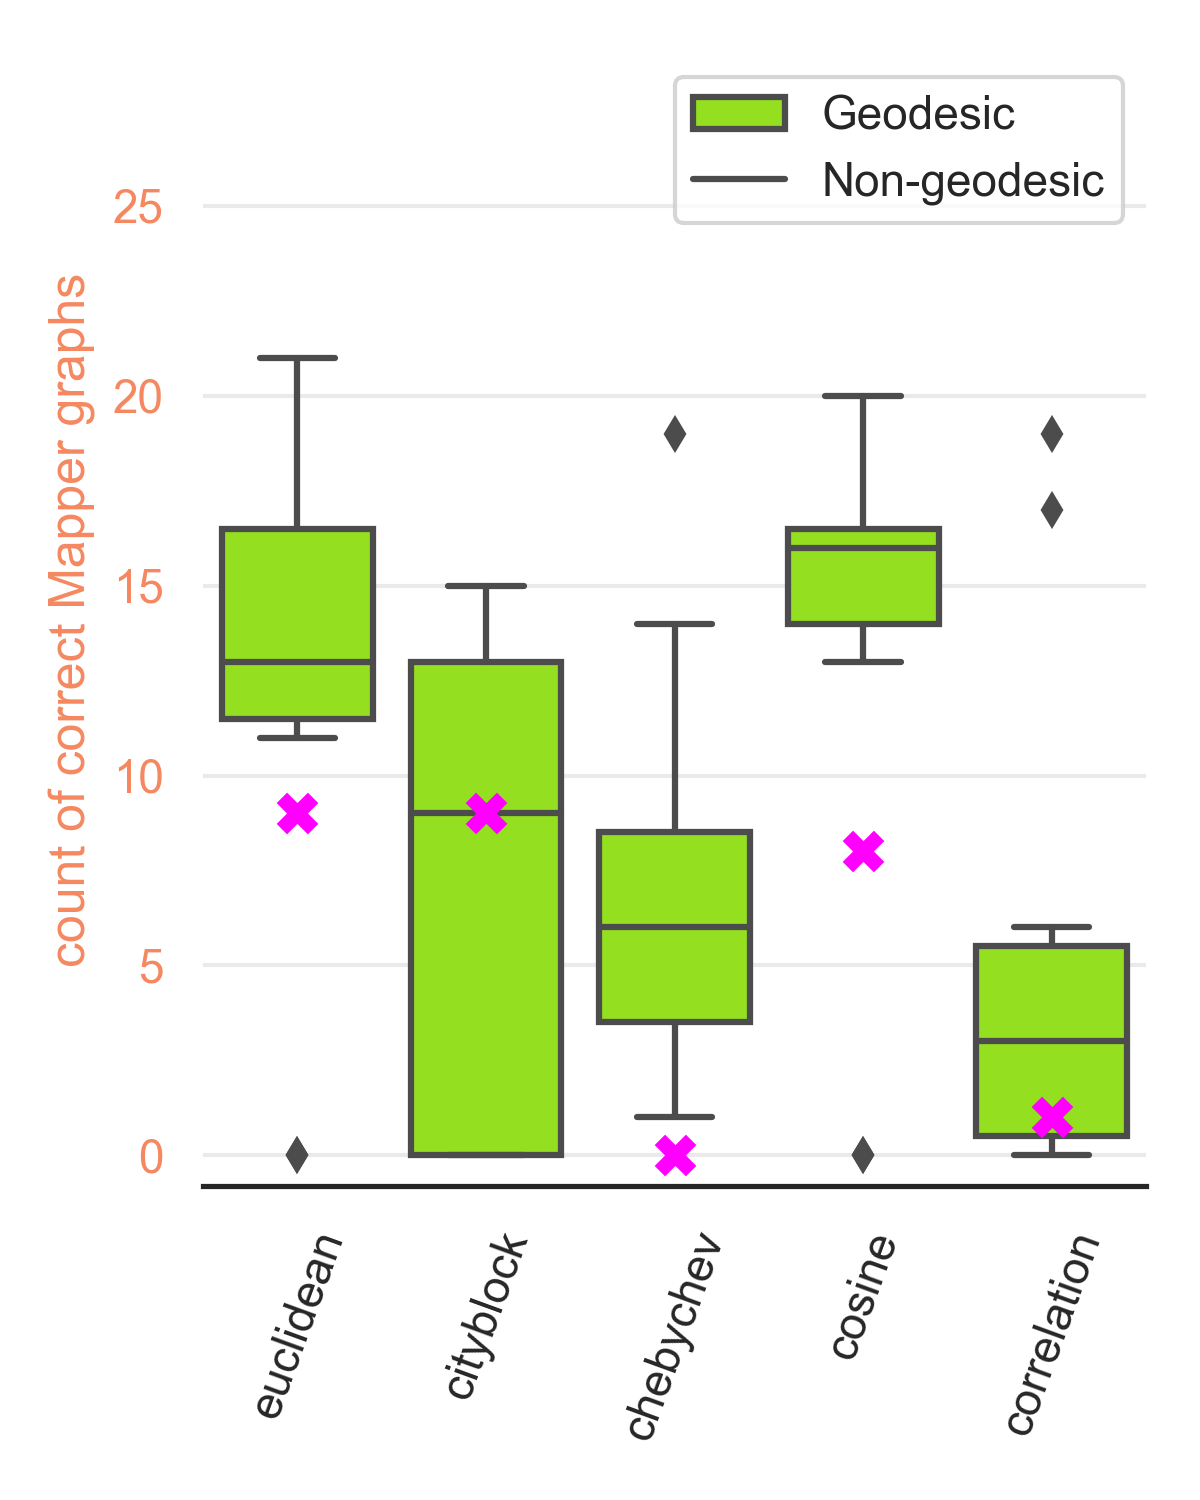

In [12]:
imgpath = 'results/w3c/analysis/mappers_w3c_dists2.json/distances_distribution_boxplot_v2.png'
display(IPyImage(filename=os.path.join('../', imgpath)))

In [13]:
fdf = counts_df.copy()
buckets = fdf['dist'].drop_duplicates().tolist()
print('ANOVA', stats.f_oneway(*[fdf[fdf['dist'] == b]['count'].tolist() for b in buckets]))

ANOVA F_onewayResult(statistic=7.893741190434977, pvalue=2.295493608691507e-05)


In [14]:
# tstatistic between magnitude and angle distances
magn_metrics = ['euclidean', 'cityblock', 'chebychev']
angl_metrics = ['cosine', 'correlation']

p1 = counts_df[counts_df['dist'].isin(magn_metrics)]['count'].tolist()
p2 = counts_df[counts_df['dist'].isin(angl_metrics)]['count'].tolist()
stats.ttest_ind(p1, p2)

Ttest_indResult(statistic=-0.08072143769679477, pvalue=0.9358702490032244)

In [15]:
counts_df['geodesic'] = counts_df['K'].str.contains('geodesic ')
p1d = counts_df[counts_df['geodesic'] == True].groupby('dist')['count'].mean().to_dict()
p2d = counts_df[counts_df['geodesic'] == False].groupby('dist')['count'].mean().to_dict()
ds = p1d.keys()
stats.ttest_rel([p1d[d] for d in ds], [p2d[d] for d in ds])

Ttest_relResult(statistic=2.255836886192383, pvalue=0.08708062947591)

### Figure (d)
This figure depends on running the config (mappers and analysis) for: "mappers_w3c_dists3".

Make sure you have run Step 2b above before running those scripts.

In [7]:
import random
from scipy import stats


sns.set(font_scale=1.5)
sns.set_style(style='white')

dists = ['chebychev', 'correlation', 'cosine', 'cityblock', 'euclidean']

PICKED_DATASET = 'w3c-dists3'
datadir = DATASETS[PICKED_DATASET]
stats_path = os.path.join(datadir, 'compute_stats-combined.csv')
results_path = os.path.join(datadir, 'scores-all.csv')

# Extract geodesic distances mappers
filter_by = FILTERS[PICKED_DATASET][0]
df_geo, max_values = extract_dataset(stats_path, results_path, filter_by, extract_params_f)
target_metrics_limits_geo = {
    'TransitionBetweeness': [0, max_values['TransitionBetweeness'] * 0.99], # Need the data first, add later
    'coverage_nodes': [0.7, 1.0],
    'distances_entropy': [2.0, 10000.0],
    'hrfdur_stat': [0.15, 1.0],
}

# Extract non-geodesic distances mappers
filter_by = FILTERS[PICKED_DATASET][1]
df_nongeo, max_values = extract_dataset(stats_path, results_path, filter_by, extract_params_f)
target_metrics_limits_nongeo = {
    'TransitionBetweeness': [0, max_values['TransitionBetweeness'] * 0.99], # Need the data first, add later
    'coverage_nodes': [0.7, 1.0],
    'distances_entropy': [2.0, 10000.0],
    'hrfdur_stat': [0.15, 1.0],
}


table = []
sbjs = df_geo['SBJ'].drop_duplicates().tolist()
sbjs = sorted([s for s in sbjs if s == 'SBJ' or 'SNR' in s])
for sbj in sbjs:
    sbj_filters = {
        'SBJ': [sbj],
    }
#     noise_added = int(sbj.replace('SBJ', '')) - 100
    snr = float(sbj.replace('SBJ-SNR', '')) if sbj != 'SBJ' else 'MAX' # TODO: handle max

    df_geodists = filter_dataframe(df_geo, sbj_filters)
    df_nongeodists = filter_dataframe(df_nongeo, sbj_filters)
    Kvals = df_geodists['K'].drop_duplicates().to_numpy()


    for dist in dists:

        fdf = filter_dataframe(df_nongeodists, { 'dist': [dist] })
        cnt = count_passing(fdf, target_metrics_limits_nongeo)
        table.append({
            'dist': dist,
            'K': 'non geodesic',
            'count': cnt,
            'perc': cnt / len(fdf) * 100.0,
            'SNR': snr
        })

        for k in sorted(Kvals):
            fdf = filter_dataframe(df_geodists, { 'dist': [dist], 'K': [k] })
            cnt = count_passing(fdf, target_metrics_limits_geo)
            table.append({
                'dist': dist,
                'K': 'geodesic k={}'.format(k),
                'count': cnt,
                'perc': cnt / len(fdf) * 100.0,
                'SNR': snr
            })
          

len(stats):  15750
len(results):  15750
len(stats):  15750
len(results):  15750


In [8]:
  
vr = 0.6
counts_df = pd.DataFrame(data=table)
counts_df['geodesic'] = counts_df['K'].str.contains('geodesic ')
counts_df['Distance Type'] = counts_df.apply(lambda row: row['dist'], axis=1)
counts_df['SNR2'] = counts_df.apply(lambda row: 'No Noise' if row['SNR'] == 'MAX' else str(row['SNR']), axis=1)

cdf = counts_df.copy()
cdf = cdf[cdf['dist'].isin(['euclidean', 'cosine', 'cityblock'])]
SNR_VALS = ['1.0', '2.0', '3.3', '5.0', '10.0', 'No Noise']
cdf = cdf[cdf['SNR2'].isin(SNR_VALS)]
cdf['SNR_index'] = cdf.apply(lambda row: SNR_VALS.index(row['SNR2']), axis=1)
cdf = cdf.sort_values(by=['SNR_index', 'dist'], ascending=False)

f,ax = plt.subplots(figsize=(8,4))
ax = sns.boxplot(
    data=cdf[cdf['geodesic'] == True], y="count", x='SNR2', hue='Distance Type', width=0.6,
    palette=[[0.4, 1, 0.3], [0.4, 0.7, 0.3], [0.4, 0.5, 0.3]]) #, size=8)

# generate non-geodesic performance
snrs = cdf['SNR2'].drop_duplicates().tolist()
ds = cdf['Distance Type'].drop_duplicates().tolist()
xs, ys = [], []
xscaler = 0.6
for i, snr in enumerate(snrs):
    for j, d in enumerate(ds):
        el = cdf[(cdf['SNR2'] == snr) & (cdf['Distance Type'] == d) & (cdf['geodesic'] == False)]['count']
        assert len(el) == 1
        mid = (len(ds) - 1) / 2
        xs.append(i + (j - mid) / mid / len(ds) * xscaler)
        ys.append(el.to_list()[0])
ax.scatter(xs, ys, color=[1.0,0.0,1.0], marker="X", s=30, label='non-geodesic', alpha=0.9)


plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.xlabel('')
plt.ylabel('')
plt.tick_params(colors='#F58860', which='both', axis='y')
plt.xticks()
plt.ylim(-vr, 25)
plt.tight_layout()
# plt.show()

save_path = os.path.join(datadir, 'xSNR_boxplot.png')
plt.savefig(save_path, dpi=300)
plt.close()


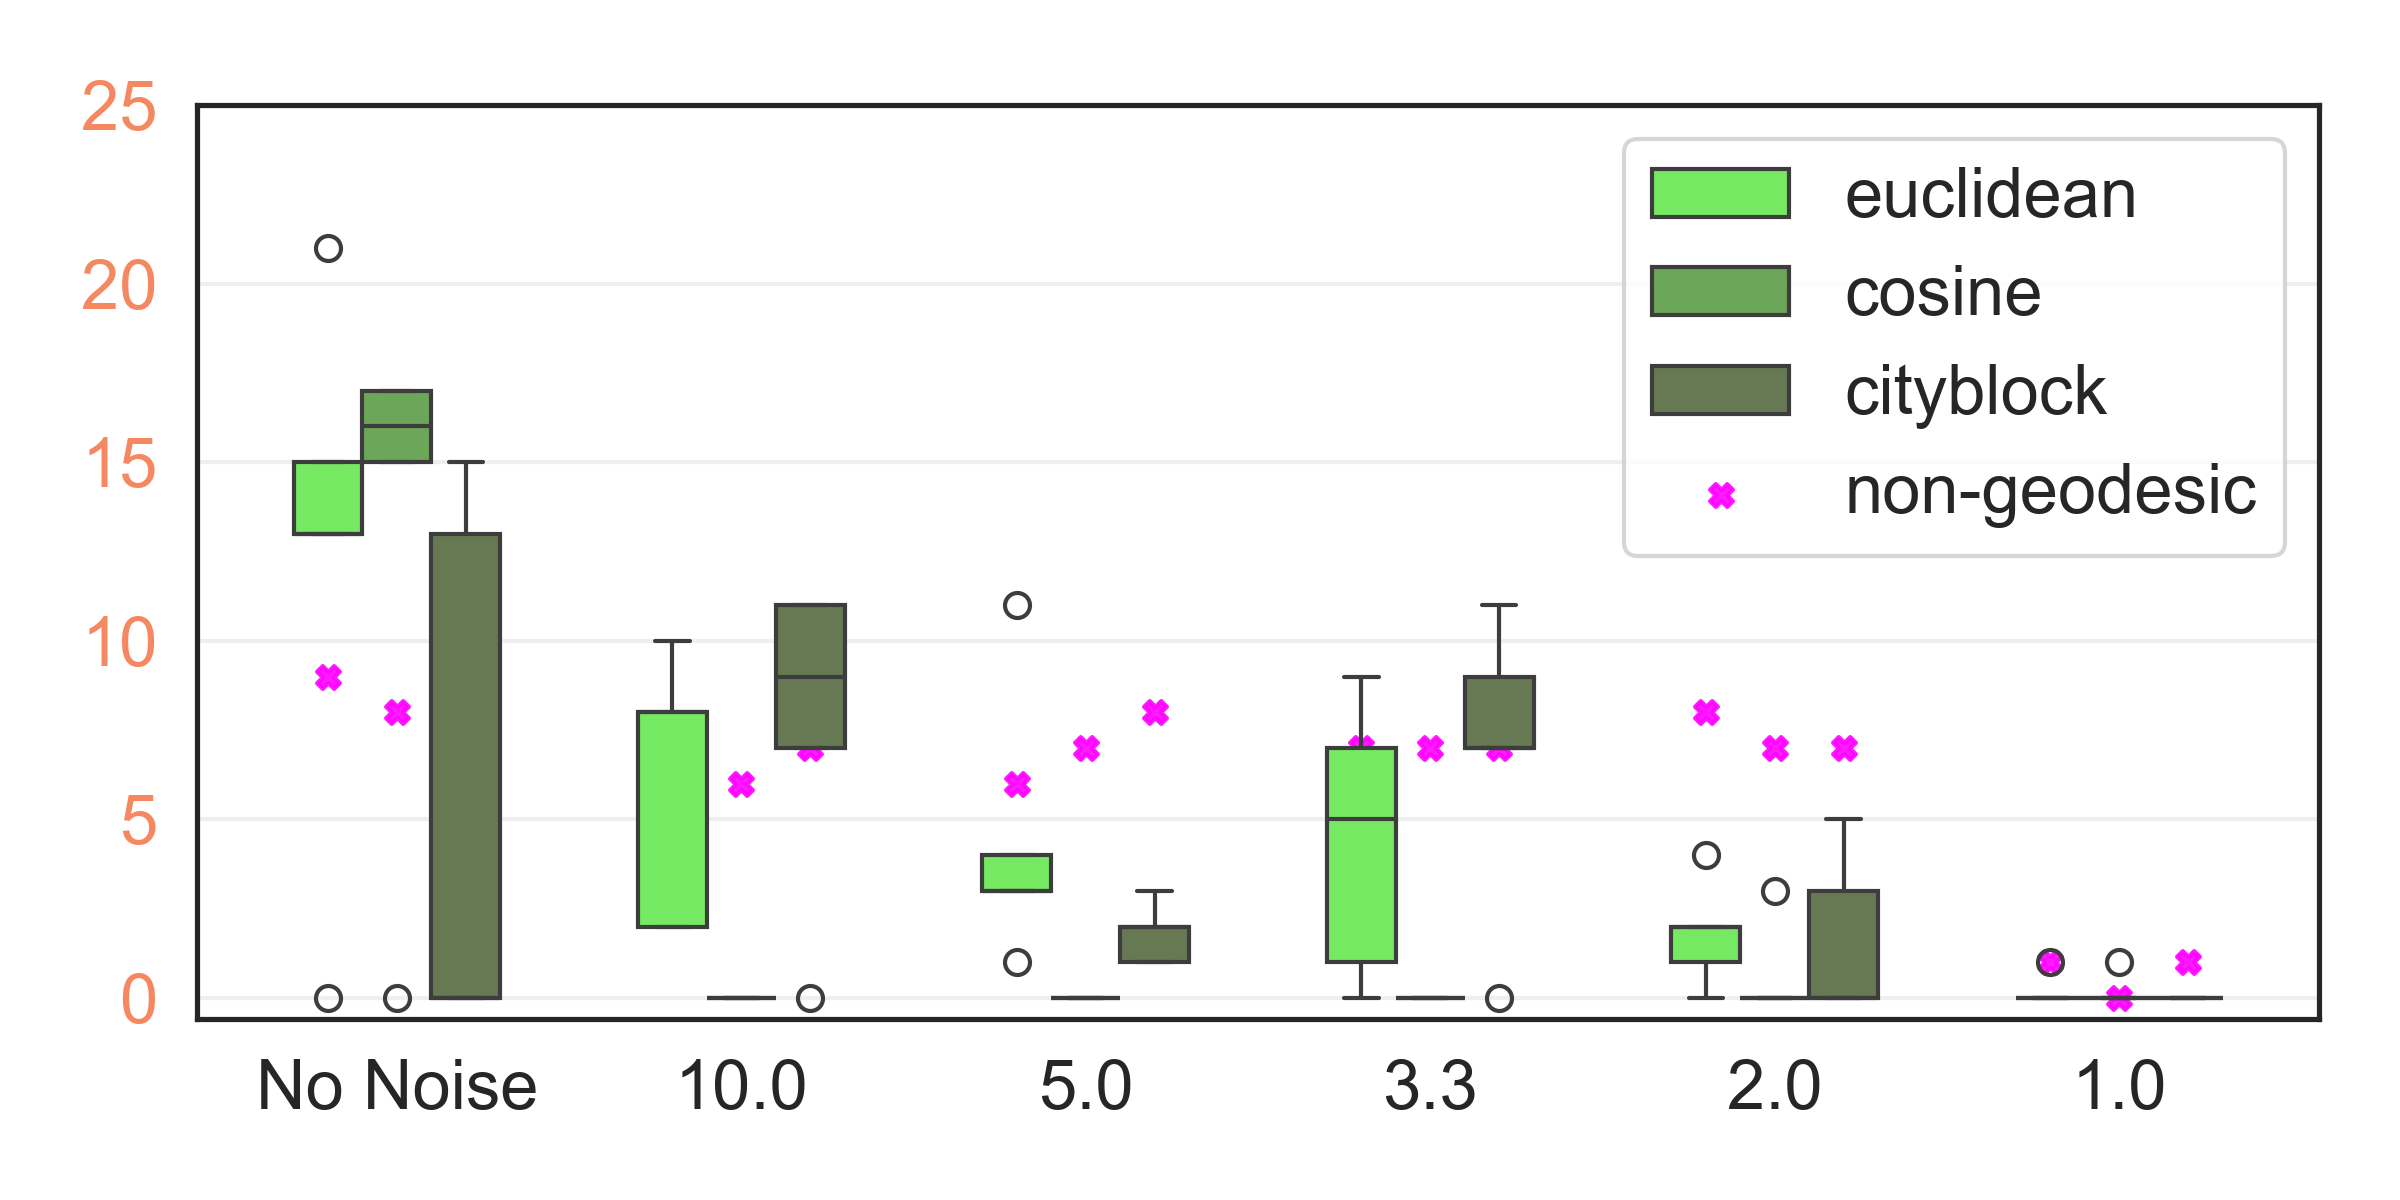

In [9]:
imgpath = 'results/w3c-wnoise/analysis/mappers_w3c_dists3.json/xSNR_boxplot.png'
display(IPyImage(filename=os.path.join('../', imgpath)))

In [10]:
cdf = counts_df.copy()
cdf['geodesic'] = cdf['K'].str.contains('geodesic ')
cdf = cdf[cdf['dist'].isin(['euclidean', 'cosine', 'cityblock'])]
p1d = cdf[(cdf['geodesic'] == True)].groupby(['SNR', 'dist'])['count'].mean().to_dict()
p2d = cdf[(cdf['geodesic'] == False)].groupby(['SNR', 'dist'])['count'].mean().to_dict()
ds = p1d.keys()

stats.ttest_rel([p1d[d] for d in ds], [p2d[d] for d in ds])

TtestResult(statistic=-3.2286974832952406, pvalue=0.0028719161276085305, df=32)

### Figure (e)
This figure depends on running the config (mappers and analysis) for: "mappers_w3c_dists4".

Make sure you have run Step 2c above before running those scripts.

In [2]:
import random
from scipy import stats

sns.set(font_scale=1.5)
sns.set_style(style='white')

dists = ['chebychev', 'correlation', 'cosine', 'cityblock', 'euclidean']

PICKED_DATASET = 'w3c-dists4'
datadir = DATASETS[PICKED_DATASET]
stats_path = os.path.join(datadir, 'compute_stats-combined.csv')
results_path = os.path.join(datadir, 'scores-all.csv')

# Extract geodesic distances mappers
filter_by = FILTERS[PICKED_DATASET][0]
df_geo, max_values = extract_dataset(stats_path, results_path, filter_by, extract_params_f)
target_metrics_limits_geo = {
    'TransitionBetweeness': [0, max_values['TransitionBetweeness'] * 0.99], # Need the data first, add later
    'coverage_nodes': [0.7, 1.0],
    'distances_entropy': [2.0, 10000.0],
    'hrfdur_stat': [0.15, 1.0],
}

# Extract non-geodesic distances mappers
filter_by = FILTERS[PICKED_DATASET][1]
df_nongeo, max_values = extract_dataset(stats_path, results_path, filter_by, extract_params_f)
target_metrics_limits_nongeo = {
    'TransitionBetweeness': [0, max_values['TransitionBetweeness'] * 0.99], # Need the data first, add later
    'coverage_nodes': [0.7, 1.0],
    'distances_entropy': [2.0, 10000.0],
    'hrfdur_stat': [0.15, 1.0],
}



len(stats):  2250
len(results):  2250
len(stats):  2250
len(results):  2250


In [3]:

table = []
sbjs = df_geo['SBJ'].drop_duplicates().tolist()
for sbj in sbjs:
    sbj_filters = {
        'SBJ': [sbj],
    }
#     noise_added = int(sbj.replace('SBJ', '')) - 100
#     snr = float(sbj.replace('SBJ-SNR', '')) if sbj != 'SBJ' else 'MAX' # TODO: handle max
    window_size = int(sbj.split('ws')[1])
    sbj.startswith('SBJe')
    skip_every = int(sbj.split('v')[0].replace('SBJe', ''))

    df_geodists = filter_dataframe(df_geo, sbj_filters)
    df_nongeodists = filter_dataframe(df_nongeo, sbj_filters)
    Kvals = df_geodists['K'].drop_duplicates().to_numpy()

    for dist in dists:
        fdf = filter_dataframe(df_nongeodists, { 'dist': [dist] })
        cnt = count_passing(fdf, target_metrics_limits_nongeo)
        table.append({
            'dist': dist,
            'K': 'non geodesic',
            'count': cnt,
            'perc': cnt / len(fdf) * 100.0,
            'window_size': window_size,
            'skip_every': skip_every
        })
        for k in sorted(Kvals):
            fdf = filter_dataframe(df_geodists, { 'dist': [dist], 'K': [k] })
            cnt = count_passing(fdf, target_metrics_limits_geo)
            table.append({
                'dist': dist,
                'K': 'geodesic k={}'.format(k),
                'count': cnt,
                'perc': cnt / len(fdf) * 100.0,
                'window_size': window_size,
                'skip_every': skip_every
            })

counts_df = pd.DataFrame(data=table)

print('max in counts_df:', counts_df['count'].max())


max in counts_df: 24


In [4]:
counts_df['Distance Type'] = counts_df.apply(lambda row: row['dist'], axis=1)
counts_df['TR_mult'] = counts_df.apply(lambda row: 'TRx{}'.format(row['skip_every']), axis=1)
counts_df['geodesic'] = counts_df['K'].str.contains('geodesic ')

cdf = counts_df.copy()
cdf = cdf[cdf['window_size'] == 4]
cdf = cdf[cdf['dist'].isin(['euclidean', 'cosine', 'cityblock'])]
cdf = cdf.sort_values(by=['skip_every', 'dist'], ascending=[True, False]) #.sort_values(by=, ascending=True)

f,ax = plt.subplots(figsize=(9,5))
sns.boxplot(
    data=cdf[cdf['geodesic']], y="count", x='TR_mult', hue='Distance Type', width=0.6,
    palette=[[0.4, 1, 0.3], [0.4, 0.7, 0.3], [0.4, 0.5, 0.3]]) #, size=8)
plt.grid(axis='y', alpha=0.3)

# generate non-geodesic performance
trs = cdf['TR_mult'].drop_duplicates().tolist()
ds = cdf['Distance Type'].drop_duplicates().tolist()
xs, ys = [], []
xscaler = 0.6
for i, t in enumerate(trs):
    for j, d in enumerate(ds):
        el = cdf[(cdf['TR_mult'] == t) & (cdf['Distance Type'] == d) & (cdf['geodesic'] == False)]['count']
        assert len(el) == 1
        mid = (len(ds) - 1) / 2
        xs.append(i + (j - mid) / mid / len(ds) * xscaler)
        ys.append(el.to_list()[0])
ax.scatter(xs, ys, color=[1.0,0.0,1.0], marker="X", s=80, label='non-geodesic', alpha=0.9)

plt.legend()
plt.xlabel('')
plt.ylabel('')
plt.tick_params(colors='#F58860', which='both', axis='y')
plt.xticks()
plt.ylim(-1, 25)
plt.tight_layout()
# plt.show()

save_path = os.path.join(datadir, 'dist_TRs_boxplot.png')
plt.savefig(save_path, dpi=300)
plt.close()

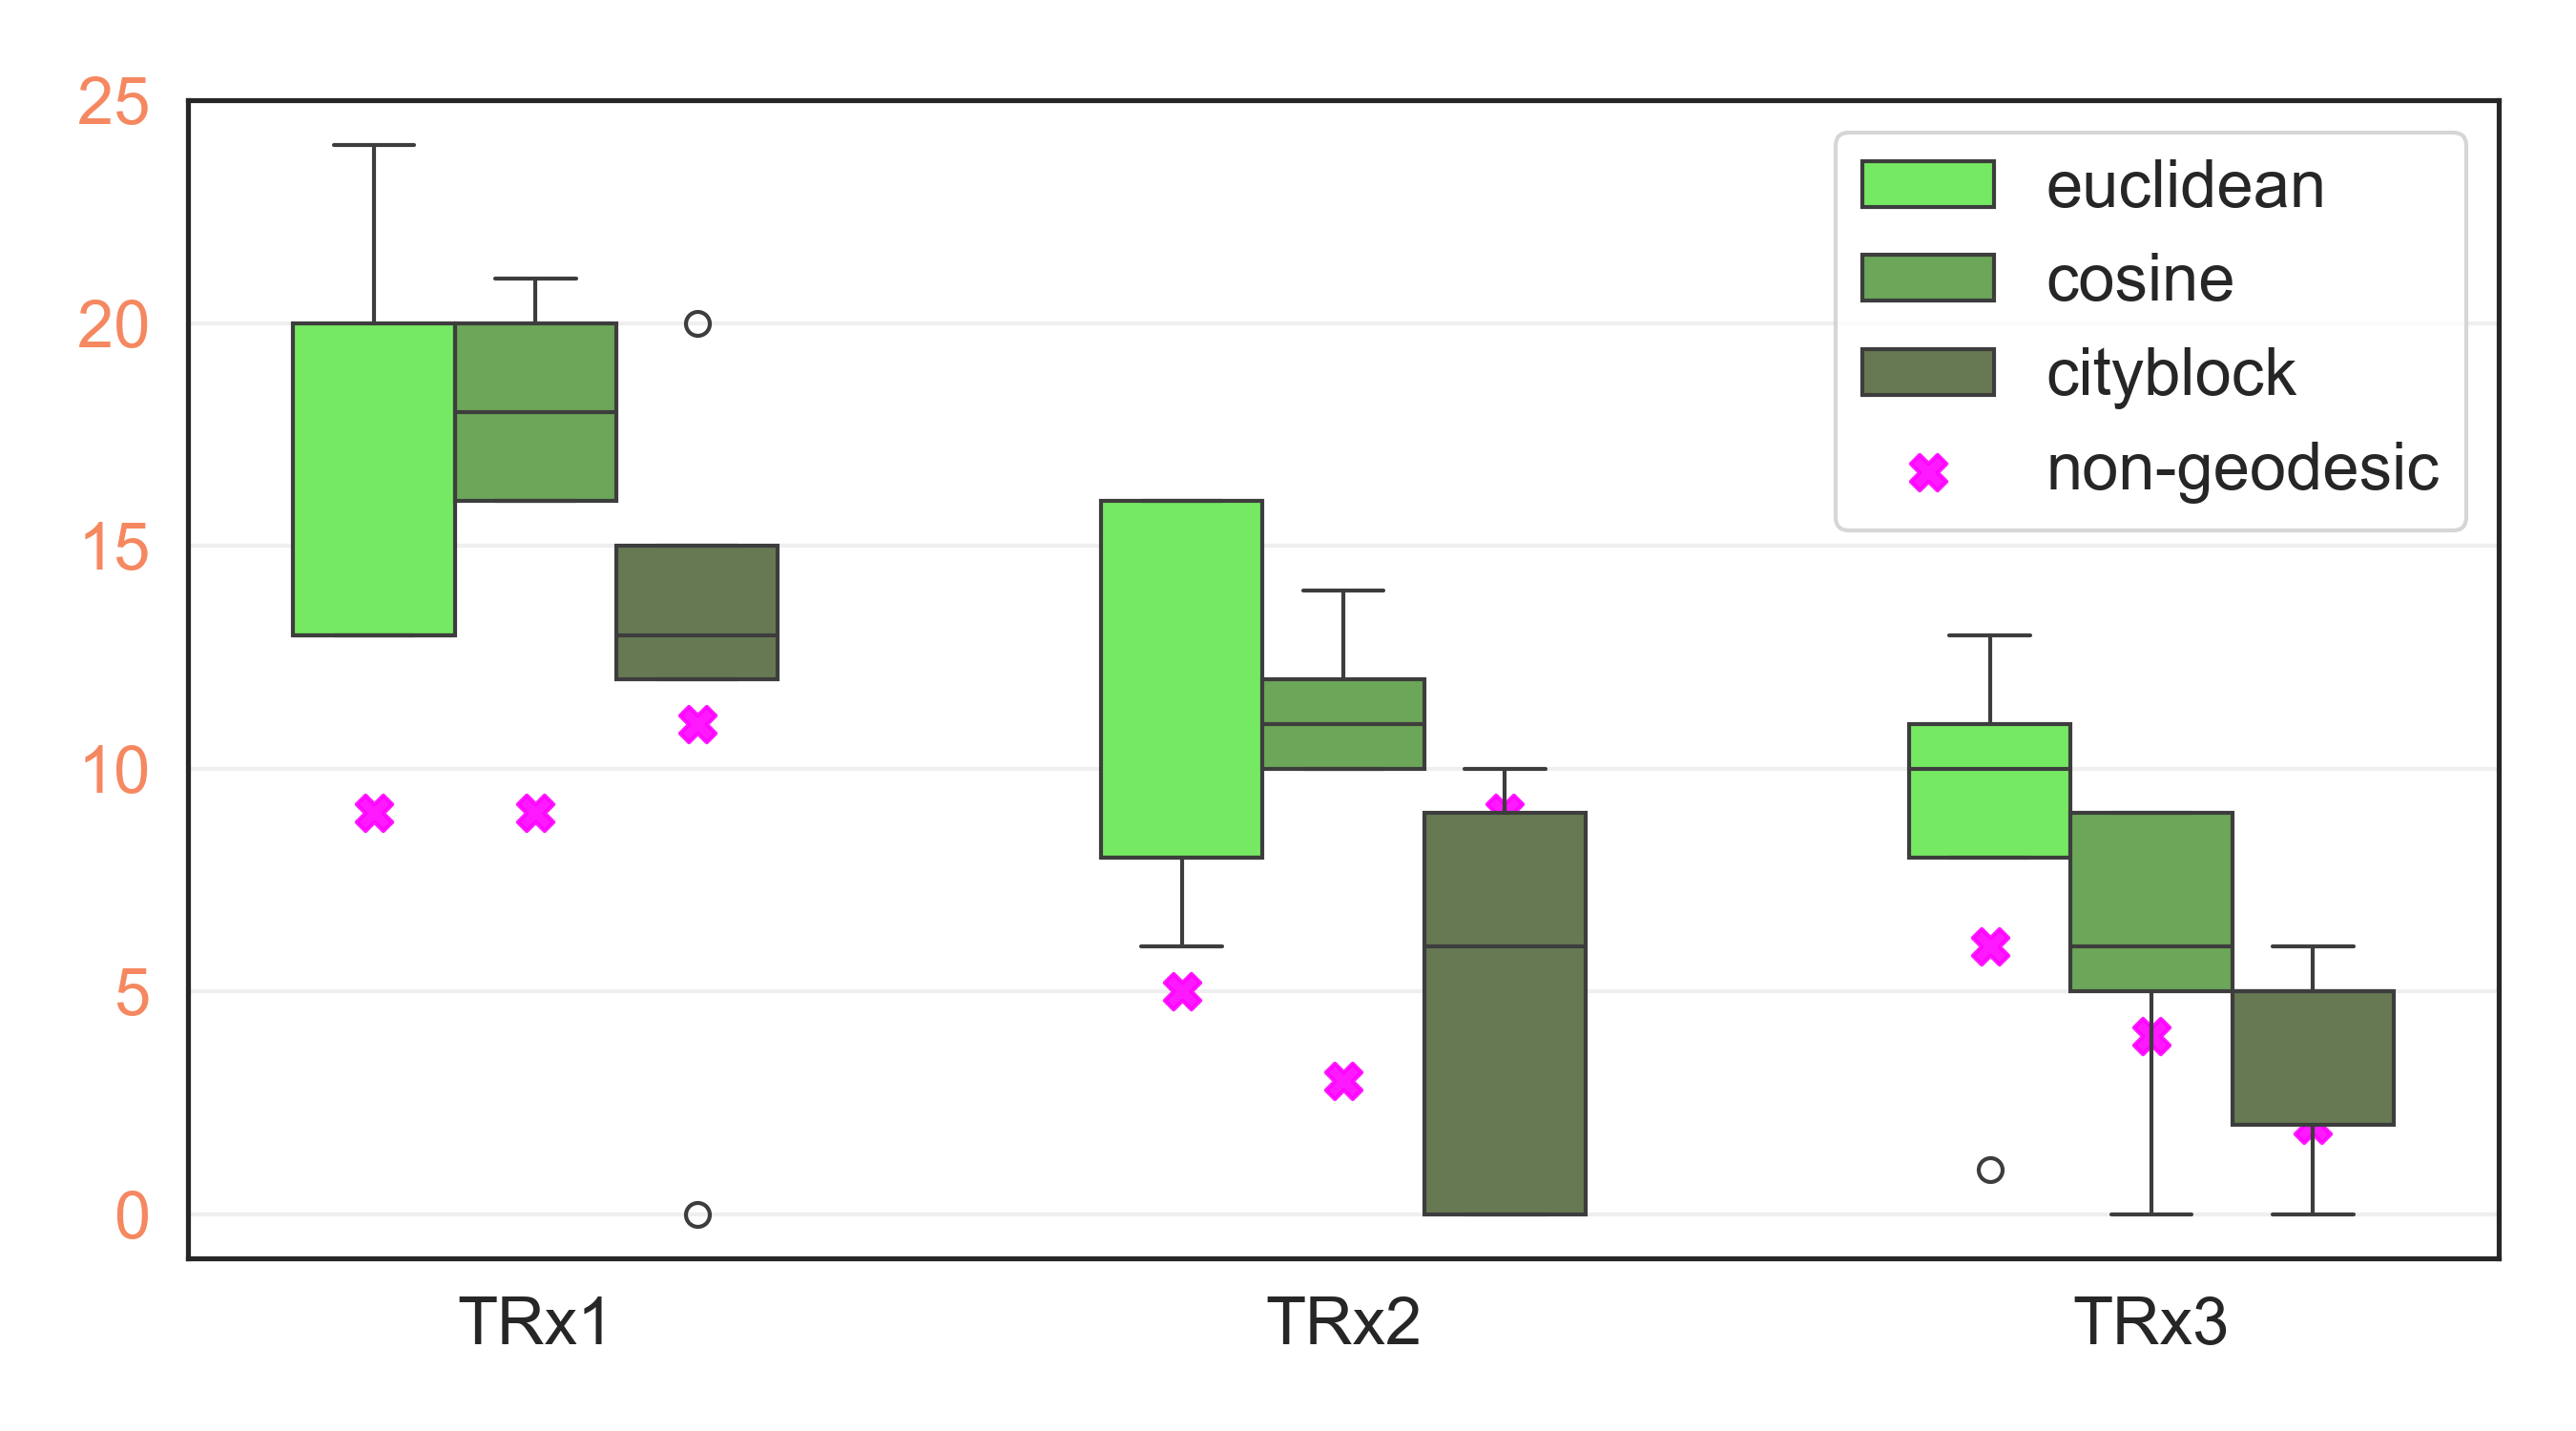

In [5]:
imgpath = 'results/w3c-hightr/analysis/mappers_w3c_dists4.json/dist_TRs_boxplot.png'
display(IPyImage(filename=os.path.join('../', imgpath)))

In [6]:
cdf = counts_df.copy()
cdf['geodesic'] = cdf['K'].str.contains('geodesic ')
# cdf = cdf[cdf['dist'].isin(['euclidean', 'cosine', 'cityblock'])]
p1d = cdf[(cdf['geodesic'] == True)].groupby(['TR_mult', 'dist'])['count'].mean().to_dict()
p2d = cdf[(cdf['geodesic'] == False)].groupby(['TR_mult', 'dist'])['count'].mean().to_dict()
ds = p1d.keys()

stats.ttest_rel([p1d[d] for d in ds], [p2d[d] for d in ds])

TtestResult(statistic=4.565950877953797, pvalue=0.00044010065593661315, df=14)

## Supplementary

In [26]:
import random
from scipy import stats


sns.set(font_scale=1.5)
sns.set_style(style='white')

dists = ['chebychev', 'correlation', 'cosine', 'cityblock', 'euclidean']

PICKED_DATASET = 'w3c-dists3'
datadir = DATASETS[PICKED_DATASET]
stats_path = os.path.join(datadir, 'compute_stats-combined.csv')
results_path = os.path.join(datadir, 'scores-all.csv')

# Extract geodesic distances mappers
filter_by = FILTERS[PICKED_DATASET][0]
df_geo, max_values = extract_dataset(stats_path, results_path, filter_by, extract_params_f)
target_metrics_limits_geo = {
    'TransitionBetweeness': [0, max_values['TransitionBetweeness'] * 0.99], # Need the data first, add later
    'coverage_nodes': [0.7, 1.0],
    'distances_entropy': [2.0, 10000.0],
    'hrfdur_stat': [0.15, 1.0],
}

# Extract non-geodesic distances mappers
filter_by = FILTERS[PICKED_DATASET][1]
df_nongeo, max_values = extract_dataset(stats_path, results_path, filter_by, extract_params_f)
target_metrics_limits_nongeo = {
    'TransitionBetweeness': [0, max_values['TransitionBetweeness'] * 0.99], # Need the data first, add later
    'coverage_nodes': [0.7, 1.0],
    'distances_entropy': [2.0, 10000.0],
    'hrfdur_stat': [0.15, 1.0],
}


table = []
sbjs = df_geo['SBJ'].drop_duplicates().tolist()
sbjs = sorted([s for s in sbjs if s == 'SBJ' or 'SNR' in s])
for sbj in sbjs:
    sbj_filters = {
        'SBJ': [sbj],
    }
#     noise_added = int(sbj.replace('SBJ', '')) - 100
    snr = float(sbj.replace('SBJ-SNR', '')) if sbj != 'SBJ' else 'MAX' # TODO: handle max

    df_geodists = filter_dataframe(df_geo, sbj_filters)
    df_nongeodists = filter_dataframe(df_nongeo, sbj_filters)
    Kvals = df_geodists['K'].drop_duplicates().to_numpy()


    for dist in dists:

        fdf = filter_dataframe(df_nongeodists, { 'dist': [dist] })
        cnt = count_passing(fdf, target_metrics_limits_nongeo)
        table.append({
            'dist': dist,
            'K': 'non geodesic',
            'count': cnt,
            'perc': cnt / len(fdf) * 100.0,
            'SNR': snr
        })

        for k in sorted(Kvals):
            fdf = filter_dataframe(df_geodists, { 'dist': [dist], 'K': [k] })
            cnt = count_passing(fdf, target_metrics_limits_geo)
            table.append({
                'dist': dist,
                'K': 'geodesic k={}'.format(k),
                'count': cnt,
                'perc': cnt / len(fdf) * 100.0,
                'SNR': snr
            })
          

len(stats):  15750
len(results):  15750
len(stats):  15750
len(results):  15750


In [27]:
  
vr = 0.6
counts_df = pd.DataFrame(data=table)
counts_df['geodesic'] = counts_df['K'].str.contains('geodesic ')
counts_df['Distance Type'] = counts_df.apply(lambda row: row['dist'], axis=1)
counts_df['SNR2'] = counts_df.apply(lambda row: 'No Noise' if row['SNR'] == 'MAX' else str(row['SNR']), axis=1)

cdf = counts_df.copy()
cdf = cdf[cdf['dist'].isin(['correlation', 'chebychev'])]
SNR_VALS = ['1.0', '2.0', '3.3', '5.0', '10.0', 'No Noise']
cdf = cdf[cdf['SNR2'].isin(SNR_VALS)]
cdf['SNR_index'] = cdf.apply(lambda row: SNR_VALS.index(row['SNR2']), axis=1)
cdf = cdf.sort_values(by=['SNR_index', 'dist'], ascending=False)

f,ax = plt.subplots(figsize=(8,4))
ax = sns.boxplot(
    data=cdf[cdf['geodesic'] == True], y="count", x='SNR2', hue='Distance Type', width=0.6,
    palette=[[0.4, 1, 0.3], [0.4, 0.7, 0.3], [0.4, 0.5, 0.3]]) #, size=8)

# generate non-geodesic performance
snrs = cdf['SNR2'].drop_duplicates().tolist()
ds = cdf['Distance Type'].drop_duplicates().tolist()
xs, ys = [], []
xscaler = 0.3
for i, snr in enumerate(snrs):
    for j, d in enumerate(ds):
        el = cdf[(cdf['SNR2'] == snr) & (cdf['Distance Type'] == d) & (cdf['geodesic'] == False)]['count']
        assert len(el) == 1
        mid = (len(ds) - 1) / 2
        xs.append(i + (j - mid) / mid / len(ds) * xscaler)
        ys.append(el.to_list()[0])
ax.scatter(xs, ys, color=[1.0,0.0,1.0], marker="X", s=30, label='non-geodesic', alpha=0.9)


plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.xlabel('')
plt.ylabel('')
plt.tick_params(colors='#F58860', which='both', axis='y')
plt.xticks()
plt.ylim(-vr, 25)
plt.tight_layout()
# plt.show()

save_path = os.path.join(datadir, 'xSNR_boxplot_other_dists.png')
plt.savefig(save_path, dpi=300)
plt.close()


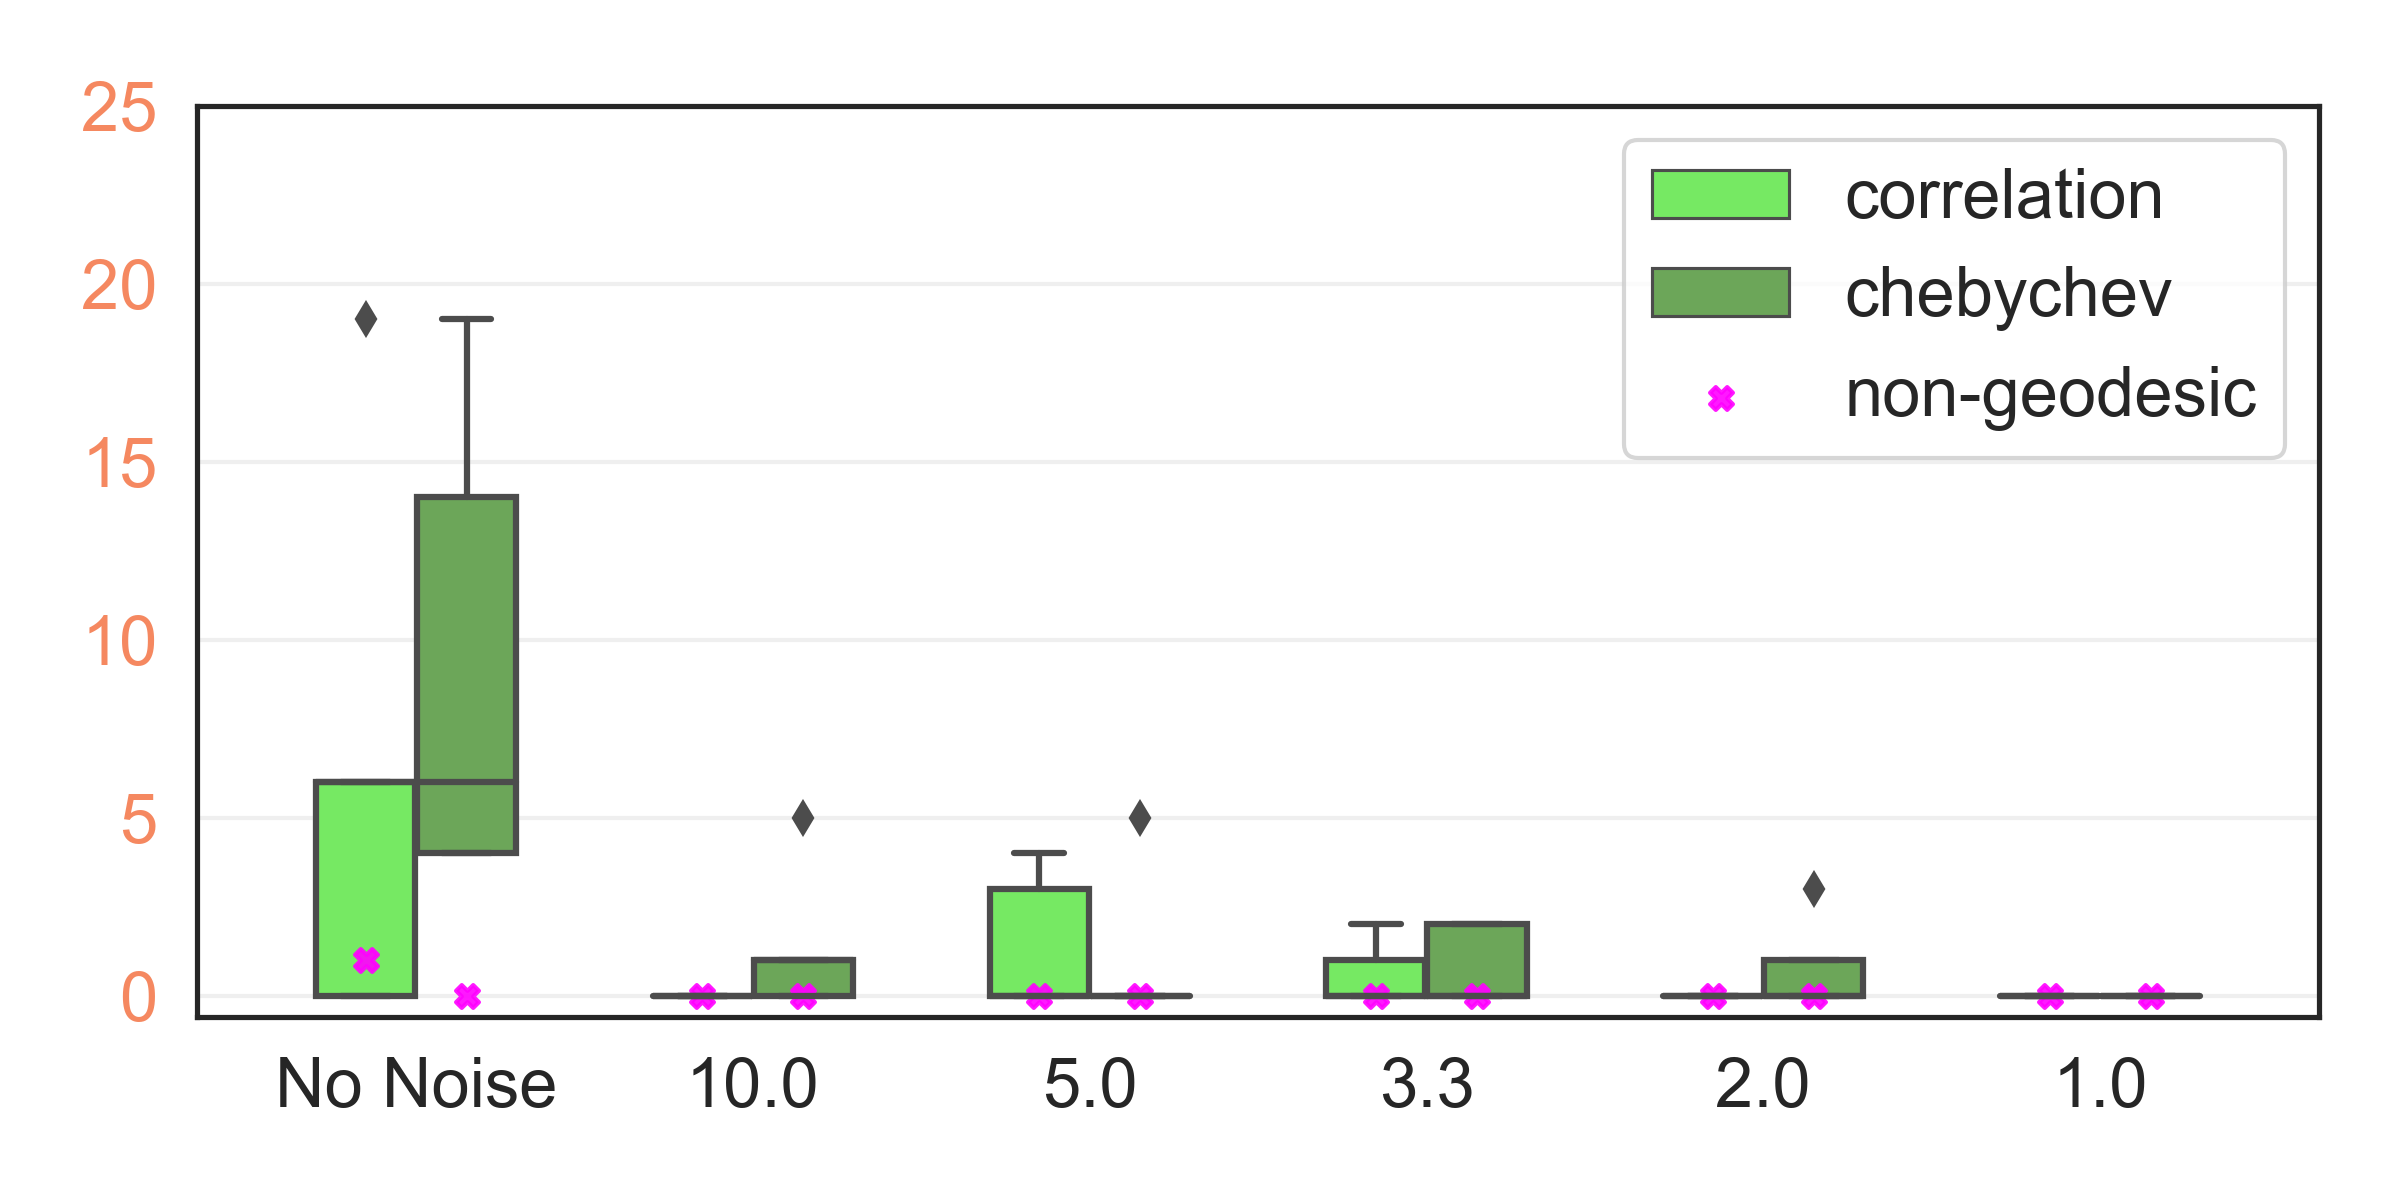

In [28]:
imgpath = 'results/w3c-wnoise/analysis/mappers_w3c_dists3.json/xSNR_boxplot_other_dists.png'
display(IPyImage(filename=os.path.join('../', imgpath)))

In [29]:
cdf = counts_df.copy()
cdf['geodesic'] = cdf['K'].str.contains('geodesic ')
ds = ['euclidean', 'cityblock', 'cosine', 'correlation']
# cdf = cdf[cdf['dist'].isin(ds)]
p1d = cdf[(cdf['geodesic'] == True)].groupby(['SNR', 'dist'])['count'].mean().to_dict()
p2d = cdf[(cdf['geodesic'] == False)].groupby(['SNR', 'dist'])['count'].mean().to_dict()

snrs = sorted(list(set([snr for snr,_ in p1d.keys() if snr != 'MAX']))) + ['MAX']
snrs = snrs[::-1]

cs = ['b', 'r', 'g', 'y']

plt.figure(figsize=(8,6))
for di, d in enumerate(ds):
    plt.plot([i for i in range(len(snrs))], [p1d[(snrs[i], d)] for i in range(len(snrs))], color=cs[di])
    plt.plot([i for i in range(len(snrs))], [p2d[(snrs[i], d)] for i in range(len(snrs))], '--', color=cs[di])

plt.legend([f'{d} {g}' for d in ds for g in ['geodesic', 'non-geodesic']])
    
plt.ylim([0, 25])
plt.xticks(range(len(snrs)), snrs)
plt.tick_params(colors='#F58860', which='both', axis='y')
plt.grid(alpha=0.2)
# plt.show()
save_path = os.path.join(datadir, 'xSNR_plot_detailed_geo_nongeo.png')
plt.savefig(save_path, dpi=300)
plt.close()

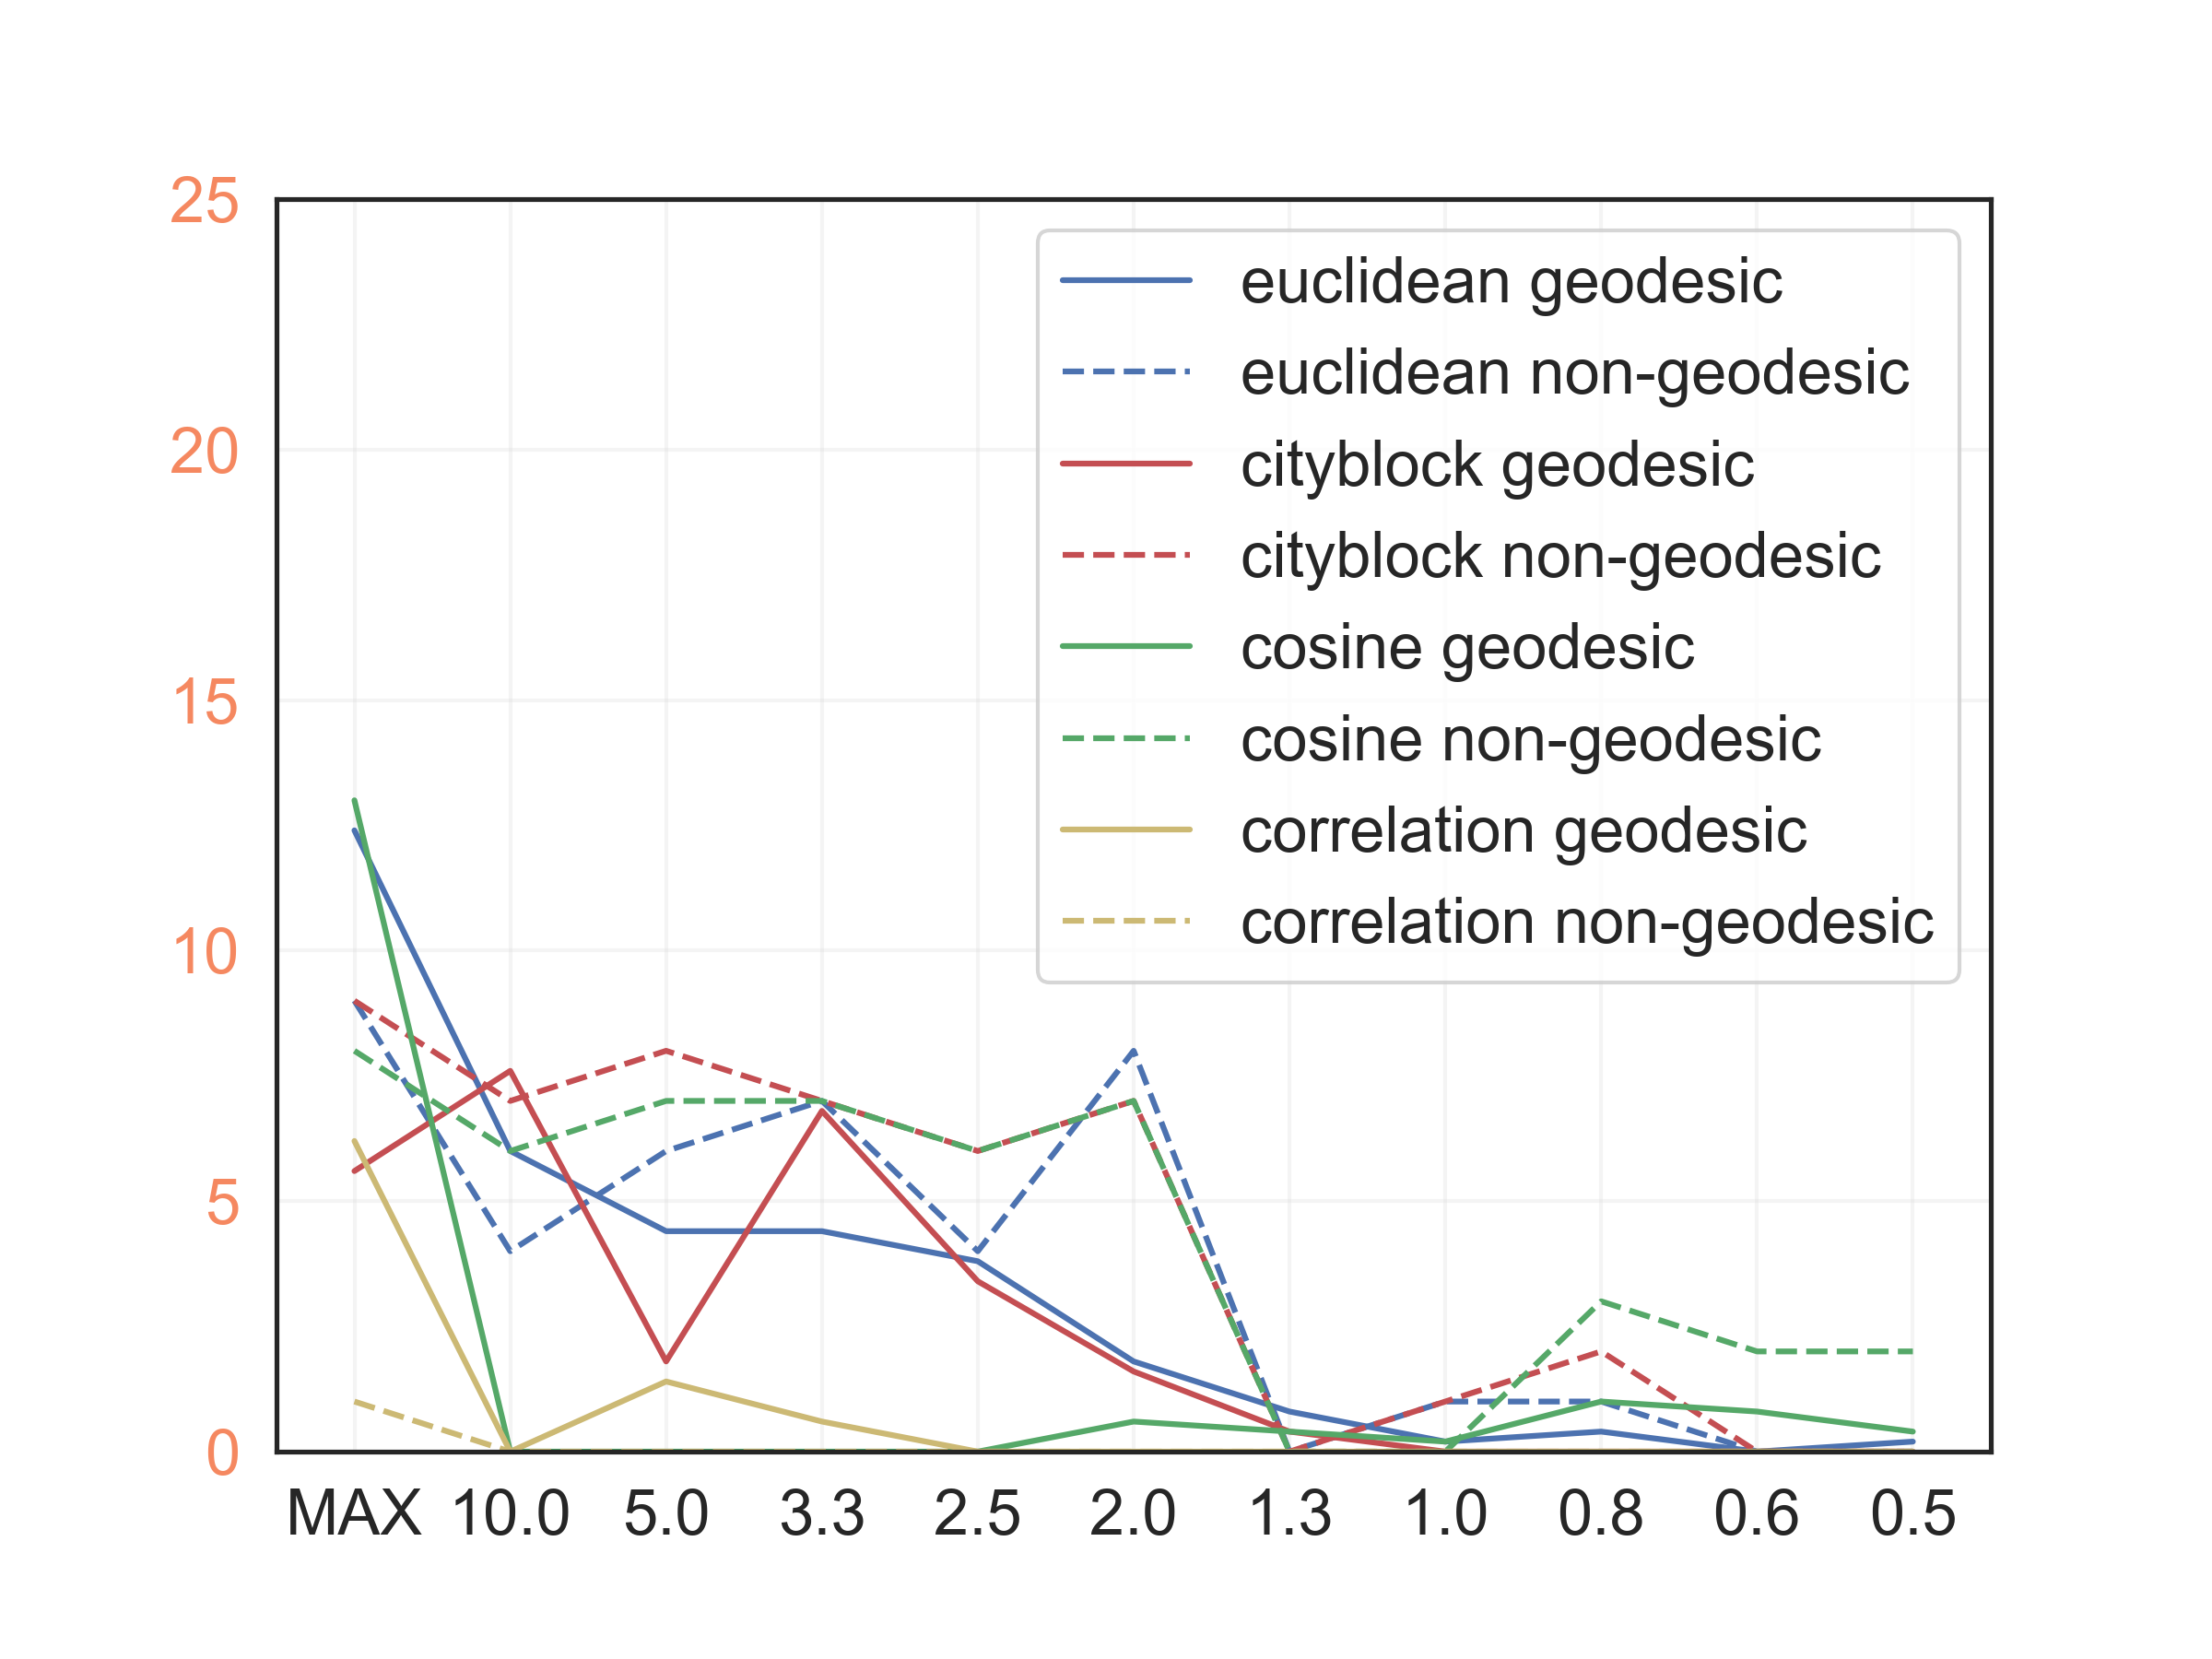

In [30]:
imgpath = 'results/w3c-wnoise/analysis/mappers_w3c_dists3.json/xSNR_plot_detailed_geo_nongeo.png'
display(IPyImage(filename=os.path.join('../', imgpath)))

### TRs supplementary

In [31]:
import random
from scipy import stats


sns.set(font_scale=1.5)
sns.set_style(style='white')

dists = ['chebychev', 'correlation', 'cosine', 'cityblock', 'euclidean']

PICKED_DATASET = 'w3c-dists4'
datadir = DATASETS[PICKED_DATASET]
stats_path = os.path.join(datadir, 'compute_stats-combined.csv')
results_path = os.path.join(datadir, 'scores-all.csv')

# Extract geodesic distances mappers
filter_by = FILTERS[PICKED_DATASET][0]
df_geo, max_values = extract_dataset(stats_path, results_path, filter_by, extract_params_f)
target_metrics_limits_geo = {
    'TransitionBetweeness': [0, max_values['TransitionBetweeness'] * 0.99], # Need the data first, add later
    'coverage_nodes': [0.7, 1.0],
    'distances_entropy': [2.0, 10000.0],
    'hrfdur_stat': [0.15, 1.0],
}

# Extract non-geodesic distances mappers
filter_by = FILTERS[PICKED_DATASET][1]
df_nongeo, max_values = extract_dataset(stats_path, results_path, filter_by, extract_params_f)
target_metrics_limits_nongeo = {
    'TransitionBetweeness': [0, max_values['TransitionBetweeness'] * 0.99], # Need the data first, add later
    'coverage_nodes': [0.7, 1.0],
    'distances_entropy': [2.0, 10000.0],
    'hrfdur_stat': [0.15, 1.0],
}



len(stats):  2250
len(results):  2250
len(stats):  2250
len(results):  2250


In [32]:

table = []
sbjs = df_geo['SBJ'].drop_duplicates().tolist()
for sbj in sbjs:
    sbj_filters = {
        'SBJ': [sbj],
    }
#     noise_added = int(sbj.replace('SBJ', '')) - 100
#     snr = float(sbj.replace('SBJ-SNR', '')) if sbj != 'SBJ' else 'MAX' # TODO: handle max
    window_size = int(sbj.split('ws')[1])
    sbj.startswith('SBJe')
    skip_every = int(sbj.split('v')[0].replace('SBJe', ''))

    df_geodists = filter_dataframe(df_geo, sbj_filters)
    df_nongeodists = filter_dataframe(df_nongeo, sbj_filters)
    Kvals = df_geodists['K'].drop_duplicates().to_numpy()

    for dist in dists:
        fdf = filter_dataframe(df_nongeodists, { 'dist': [dist] })
        cnt = count_passing(fdf, target_metrics_limits_nongeo)
        table.append({
            'dist': dist,
            'K': 'non geodesic',
            'count': cnt,
            'perc': cnt / len(fdf) * 100.0,
            'window_size': window_size,
            'skip_every': skip_every
        })
        for k in sorted(Kvals):
            fdf = filter_dataframe(df_geodists, { 'dist': [dist], 'K': [k] })
            cnt = count_passing(fdf, target_metrics_limits_geo)
            table.append({
                'dist': dist,
                'K': 'geodesic k={}'.format(k),
                'count': cnt,
                'perc': cnt / len(fdf) * 100.0,
                'window_size': window_size,
                'skip_every': skip_every
            })

counts_df = pd.DataFrame(data=table)

print('max in counts_df:', counts_df['count'].max())


max in counts_df: 24


In [33]:
counts_df['Distance Type'] = counts_df.apply(lambda row: row['dist'], axis=1)
counts_df['TR_mult'] = counts_df.apply(lambda row: 'TRx{}'.format(row['skip_every']), axis=1)
counts_df['geodesic'] = counts_df['K'].str.contains('geodesic ')

cdf = counts_df.copy()
cdf = cdf[cdf['window_size'] == 4]
cdf = cdf[cdf['dist'].isin(['correlation', 'chebychev'])]
cdf = cdf.sort_values(by=['skip_every', 'dist'], ascending=[True, False]) #.sort_values(by=, ascending=True)

f,ax = plt.subplots(figsize=(9,5))
sns.boxplot(
    data=cdf[cdf['geodesic']], y="count", x='TR_mult', hue='Distance Type', width=0.6,
    palette=[[0.4, 1, 0.3], [0.4, 0.7, 0.3], [0.4, 0.5, 0.3]]) #, size=8)
plt.grid(axis='y', alpha=0.3)

# generate non-geodesic performance
trs = cdf['TR_mult'].drop_duplicates().tolist()
ds = cdf['Distance Type'].drop_duplicates().tolist()
xs, ys = [], []
xscaler = 0.3
for i, t in enumerate(trs):
    for j, d in enumerate(ds):
        el = cdf[(cdf['TR_mult'] == t) & (cdf['Distance Type'] == d) & (cdf['geodesic'] == False)]['count']
        assert len(el) == 1
        mid = (len(ds) - 1) / 2
        xs.append(i + (j - mid) / mid / len(ds) * xscaler)
        ys.append(el.to_list()[0])
ax.scatter(xs, ys, color=[1.0,0.0,1.0], marker="X", s=80, label='non-geodesic', alpha=0.7)

plt.legend()
plt.xlabel('')
plt.ylabel('')
plt.tick_params(colors='#F58860', which='both', axis='y')
plt.xticks()
plt.ylim(-1, 25)
plt.tight_layout()
# plt.show()

save_path = os.path.join(datadir, 'dist_TRs_boxplot_othermetrics.png')
plt.savefig(save_path, dpi=300)
plt.close()

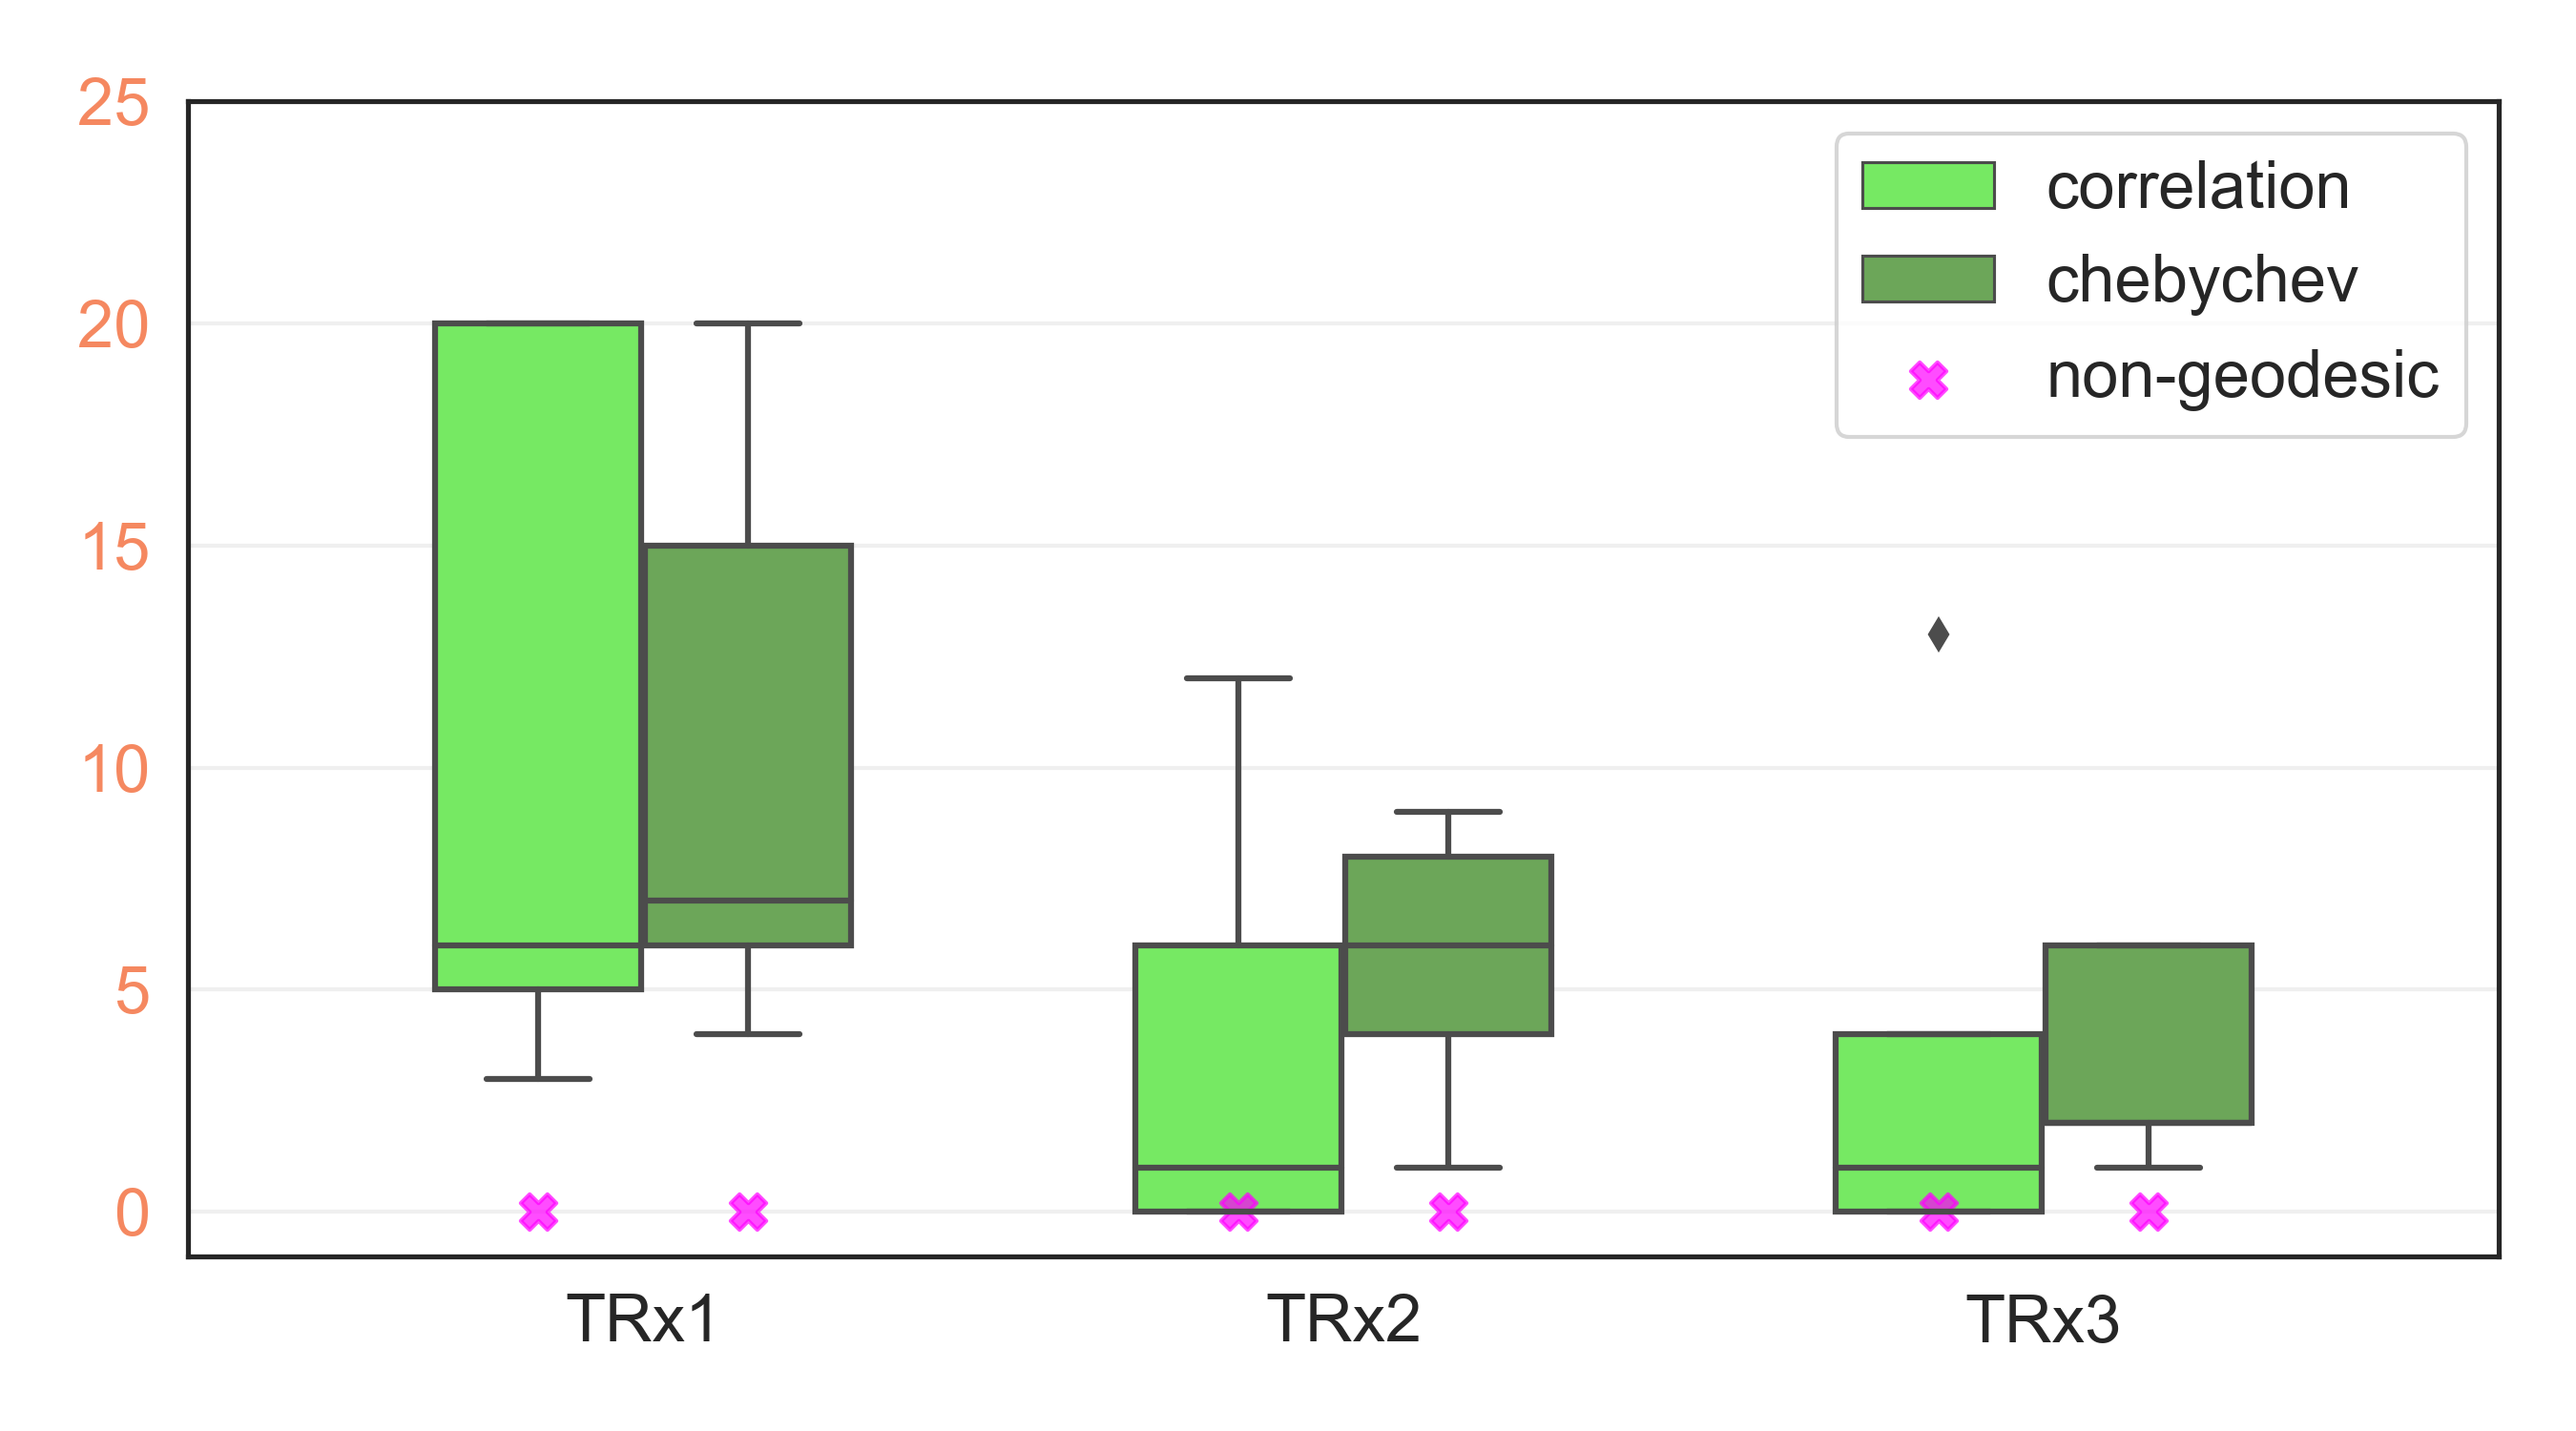

In [34]:
imgpath = 'results/w3c-hightr/analysis/mappers_w3c_dists4.json/dist_TRs_boxplot_othermetrics.png'
display(IPyImage(filename=os.path.join('../', imgpath)))